In [1]:
import os
import glob
import json
import xml.etree.ElementTree as ET

import cv2
import pandas
import openslide
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain
import matplotlib.pyplot as plt

from pyslide import slide, patching, Stitching
from pyslide.utilities import mask2rgb


In [2]:
#asap_path='data/annotations/asap_annotations.xml'
#imagej_path='data/annotations/imagej_annotations.xml'
#json_path='data/annotations/json_annotations.json'
#csv_path='data/annotations/csv_annotations.csv'
#WSI_PATH='/Volumes/cancerbioin/barts/lymphnode-paper-set/2865 B2 LN.ndpi'
QUPATH_PATH='/Users/w2030634/Projects/PySlide/data/annotations/qupath.json'
WSI_PATH='2865 B2 LN.ndpi'

border:[(3981.0, 118531.0), (11202.0, 92659.0)]


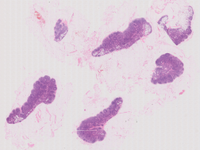

In [3]:
annotate=slide.Annotations([QUPATH_PATH],source="qupath",labels=['sinus','follicle','germinal centre'])
wsi=slide.Slide(WSI_PATH,mag=0,annotations=annotate)
mask=wsi.slide_mask
print('border:{}'.format(wsi.get_border()))
wsi.get_thumbnail((200,200))

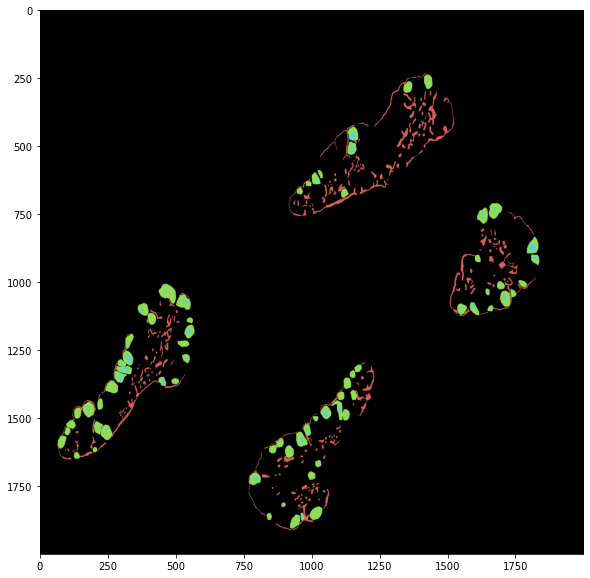

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(mask)

### Resize border 

In [5]:
print('border:{}'.format(wsi.get_border()))
borders=wsi.get_border()
x_new=wsi.resize_border(borders[0][0],factor=32)
x_new

border:[(3981.0, 118531.0), (11202.0, 92659.0)]


4000

### Detect components

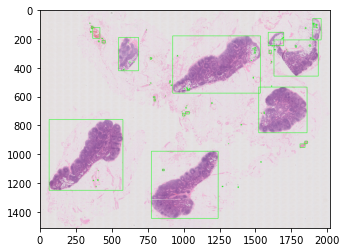

In [6]:
img,borders=wsi.detect_components()
plt.imshow(img[-1])

### Generate region

In [19]:
wsi.dimensions
border=borders[14]
(x1,x2),(y1,y2)=border
border

[(4032, 36864), (48576, 17152)]

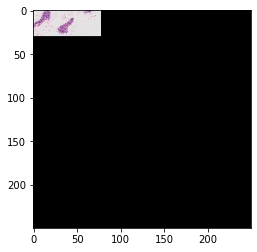

In [22]:
wsi2=openslide.OpenSlide(WSI_PATH)
region=wsi2.read_region((4032,48576),3,(50000,50000))
region_new=cv2.resize(np.array(region.convert('RGB')),(250,250))
plt.imshow(region_new)

In [ ]:
region=wsi.generate_region(mag=3,x=(x1,x2),y=(y1,y2),x_size=50000,y_size=50000)
plt.imshow(region[0])

## Patching

In [5]:
patch=patching.Patching(wsi,mag_level=3,step=1024,size=(1024,1024))
print(patch)
patch.save('images',mask_flag=True)

num patches: 96
{'name': '2865 B2 LN.ndpi', 'mag': 3, 'size': (1024, 1024), 'step': 1024, 'border': [(3981.0, 118531.0), (11202.0, 92659.0)], 'mode': None, 'number': 96}


### filter patches

Num removed: 73
Remaining:23


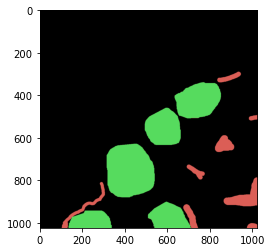

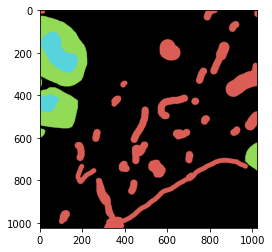

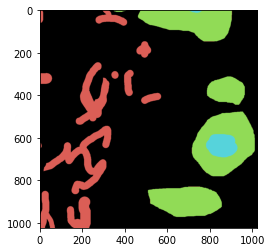

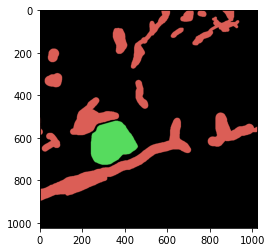

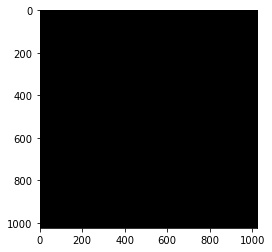

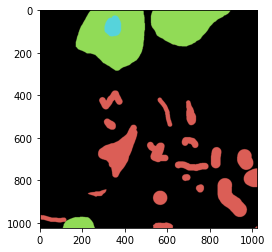

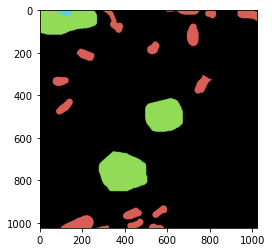

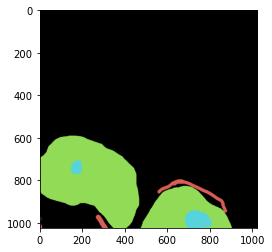

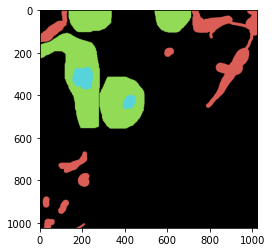

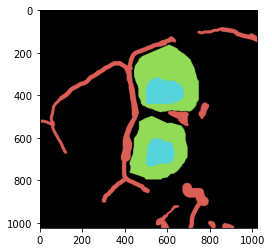

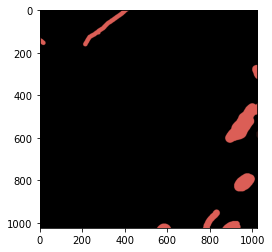

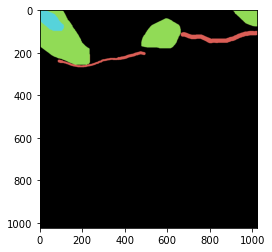

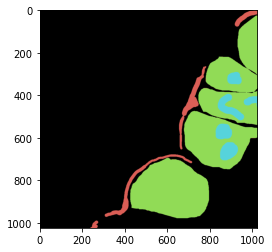

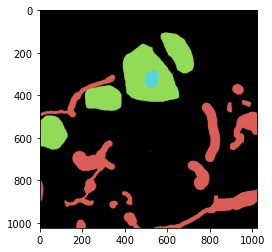

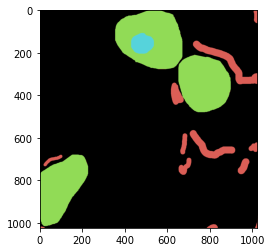

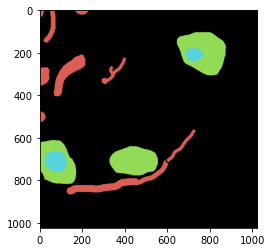

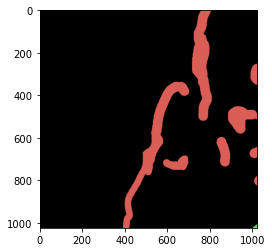

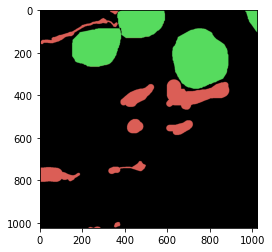

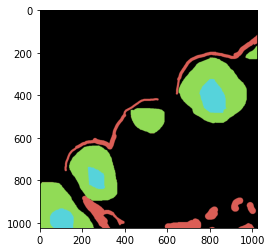

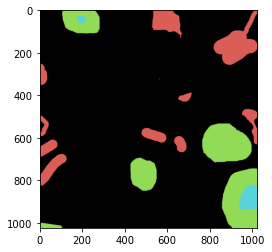

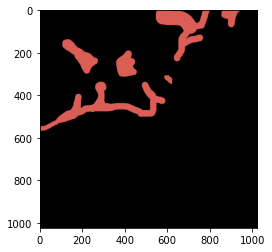

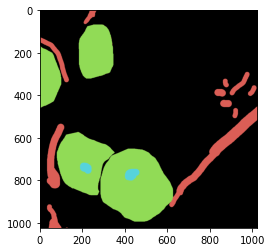

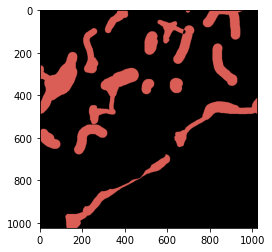

In [5]:
patch.filter_patches(210)
patch.save('images',mask_flag=True)
masks=glob.glob('images/masks/*')
for m in masks:
    mask=cv2.imread(m)
    mask=mask2rgb(mask[:,:,0])
    plt.imshow(mask)
    plt.show()

### Get labels

In [6]:
patch.generate_labels(0.5)

TypeError: '<' not supported between instances of 'int' and 'NoneType'

[[12173, 102285], [19394, 76738]]

In [5]:
xmin,xmax=stitch.border[0][0],stitch.border[0][1]
ymin,ymax=stitch.border[1][0],stitch.border[1][1]

NameError: name 'stitch' is not defined

In [7]:
ymin,ymax=stitch.border[1][0],stitch.border[1][1]

NameError: name 'stitch' is not defined

In [8]:
(ymax-ymin)/(1024*8),(xmax-xmin)/(1024*8)

NameError: name 'ymax' is not defined

### Stitching

In [6]:
stitch=Stitching('images/images',name='2865 B2 LN.ndpi',mag_level=3)

found 96 patches
border [[12173, 102285], [19394, 76738]]
step 1024


In [7]:
canvas=stitch.stitch(size=(2500,2500))

In [14]:
1985/8

248.125

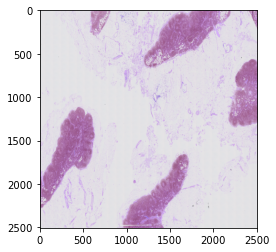

In [8]:
plt.imshow(canvas)

In [10]:
2

2016

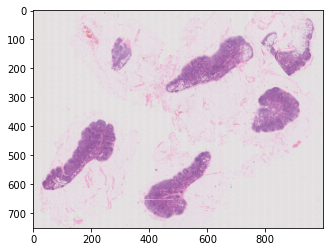

(<AxesSubplot:>,
 [<matplotlib.lines.Line2D at 0x15ff9b4f0>])

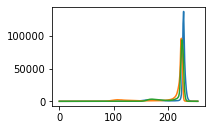

In [24]:
image=np.array(wsi.get_thumbnail((1000,1000)))
plt.imshow(image)
plt.show()
hist1 = cv2.calcHist([image],[0],None,[256],[0,256])
hist2 = cv2.calcHist([image],[1],None,[256],[0,256])
hist3 = cv2.calcHist([image],[2],None,[256],[0,256])
plt.subplot(222), plt.plot(hist1), plt.plot(hist2),plt.plot(hist3)

### Stitching

In [2]:
path='images/images'
s=patching.Stitching(path,name='2865 B2 LN.ndpi',mag_level=3)
print('patch step {}'.format(s.step))

found 96 patches
border [[12173, 102285], [19394, 76738]]
step 1024
patch step 1024


In [3]:
image=s.stitch()

UnboundLocalError: local variable 'ydim_new' referenced before assignment

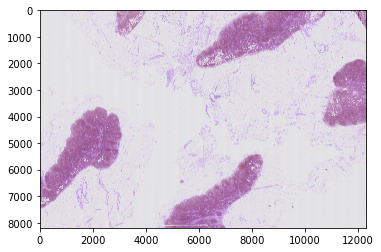

In [15]:
plt.imshow(image)